In [1]:
import pandas as pd
import numpy as np
import scikitplot
import random
import seaborn as sns
import keras
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import warnings
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
warnings.simplefilter("ignore")
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
import plotly.express as px
import copy
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.metrics import classification_report
import mlflow
import dagshub
dagshub.init(repo_owner='amenallahbenothmen', repo_name='Emotion_detection_model', mlflow=True)

Accessing as amenallahbenothmen

Initialized MLflow to track repo "amenallahbenothmen/Emotion_detection_model"

Repository amenallahbenothmen/Emotion_detection_model initialized!

In [2]:
from sklearn.preprocessing import Normalizer

In [3]:
data = pd.read_csv("fer2013.csv")
data = data.sample(frac=1).reset_index(drop=True)

In [4]:
train_pixels = data["pixels"].astype(str).str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)
pixels = np.array(train_pixels).reshape((data.shape[0], 48, 48, 1))

In [5]:
from sklearn.preprocessing import Normalizer

In [6]:
normalizer = Normalizer()
pixels = normalizer.fit_transform(pixels.reshape(pixels.shape[0], -1)).reshape(pixels.shape)


In [7]:
labels = to_categorical(data[['emotion']], num_classes=7)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [10]:
data_rus = copy.deepcopy(data)
data_smote = copy.deepcopy(data)

In [11]:
train_pixels_smote = data_smote["pixels"].astype(str).str.split(" ").tolist()
train_pixels_rus = data_rus["pixels"].astype(str).str.split(" ").tolist()

In [12]:
train_pixels_smote = np.uint8(train_pixels_smote)
train_pixels_rus = np.uint8(train_pixels_rus)


In [13]:
pixels_smote = np.array(train_pixels_smote).reshape((data_smote.shape[0], 48, 48, 1))
pixels_rus = np.array(train_pixels_rus).reshape((data_rus.shape[0], 48, 48, 1))

# Normalize the pixels
pixels_smote = normalizer.fit_transform(pixels_smote.reshape(pixels_smote.shape[0], -1)).reshape(pixels_smote.shape)
pixels_rus = normalizer.fit_transform(pixels_rus.reshape(pixels_rus.shape[0], -1)).reshape(pixels_rus.shape)

# Convert labels to categorical for SMOTE and RUS
labels_smote = to_categorical(data_smote[['emotion']], num_classes=7)
labels_rus = to_categorical(data_rus[['emotion']], num_classes=7)

In [14]:
X_flat_smote = pixels_smote.reshape(pixels_smote.shape[0], -1)
X_flat_rus = pixels_rus.reshape(pixels_rus.shape[0], -1)

In [15]:
rus = RandomUnderSampler(sampling_strategy='auto')
X_resampled_rus, y_resampled_rus = rus.fit_resample(X_flat_rus, np.argmax(labels_rus, axis=1))
X_resampled_rus = X_resampled_rus.reshape(X_resampled_rus.shape[0], 48, 48, 1)  # Reshape back to 48x48x1
y_resampled_rus = to_categorical(y_resampled_rus, num_classes=7)


In [16]:
smote = SMOTE(sampling_strategy='auto')
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_flat_smote, np.argmax(labels_smote, axis=1))
X_resampled_smote = X_resampled_smote.reshape(X_resampled_smote.shape[0], 48, 48, 1)
y_resampled_smote = to_categorical(y_resampled_smote, num_classes=7)

In [17]:
from sklearn.utils import shuffle

In [18]:
def create_balanced_split(X, y, train_size=0.7, val_size=0.2, test_size=0.1):
    # Ensure data is shuffled
    X, y = shuffle(X, y)
    
    # Count the number of samples per class
    num_classes = y.shape[1]
    class_counts = np.sum(y, axis=0)
    
    # Determine the number of samples per class in each split
    num_samples_per_class = np.min(class_counts)
    num_train_per_class = int(num_samples_per_class * train_size)
    num_val_per_class = int(num_samples_per_class * val_size)
    num_test_per_class = int(num_samples_per_class * test_size)

    # Create the splits
    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test, y_test = [], []

    for i in range(num_classes):
        class_indices = np.where(np.argmax(y, axis=1) == i)[0]
        class_X = X[class_indices]
        class_y = y[class_indices]

        # Shuffle class-specific data
        class_X, class_y = shuffle(class_X, class_y)
        
        # Split class-specific data
        X_train.extend(class_X[:num_train_per_class])
        y_train.extend(class_y[:num_train_per_class])
        
        X_val.extend(class_X[num_train_per_class:num_train_per_class+num_val_per_class])
        y_val.extend(class_y[num_train_per_class:num_train_per_class+num_val_per_class])
        
        X_test.extend(class_X[num_train_per_class+num_val_per_class:num_train_per_class+num_val_per_class+num_test_per_class])
        y_test.extend(class_y[num_train_per_class+num_val_per_class:num_train_per_class+num_val_per_class+num_test_per_class])

    # Convert lists back to arrays
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)
    X_test, y_test = np.array(X_test), np.array(y_test)

    return X_train, y_train, X_val, y_val, X_test, y_test

# For RUS data
X_train_rus, y_train_rus, X_val_rus, y_val_rus, X_test_rus, y_test_rus = create_balanced_split(X_resampled_rus, y_resampled_rus)

# For SMOTE data
X_train_smote, y_train_smote, X_val_smote, y_val_smote, X_test_smote, y_test_smote = create_balanced_split(X_resampled_smote, y_resampled_smote)

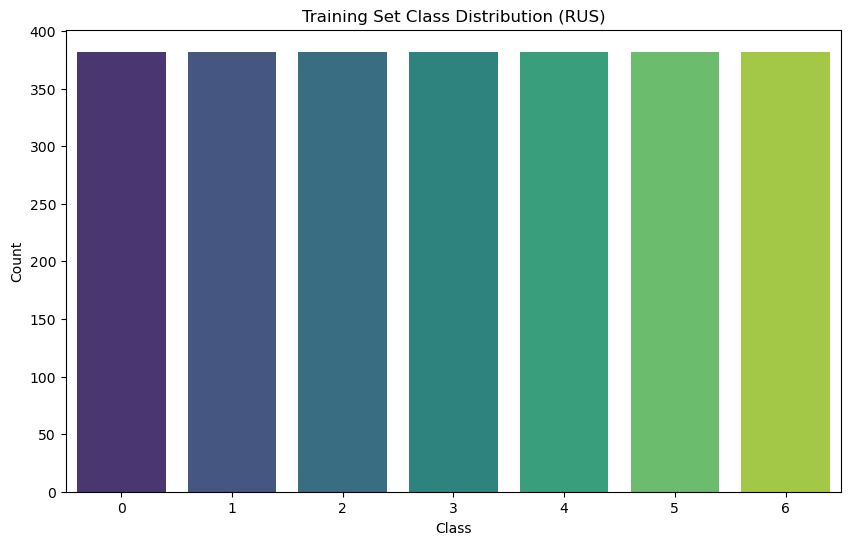

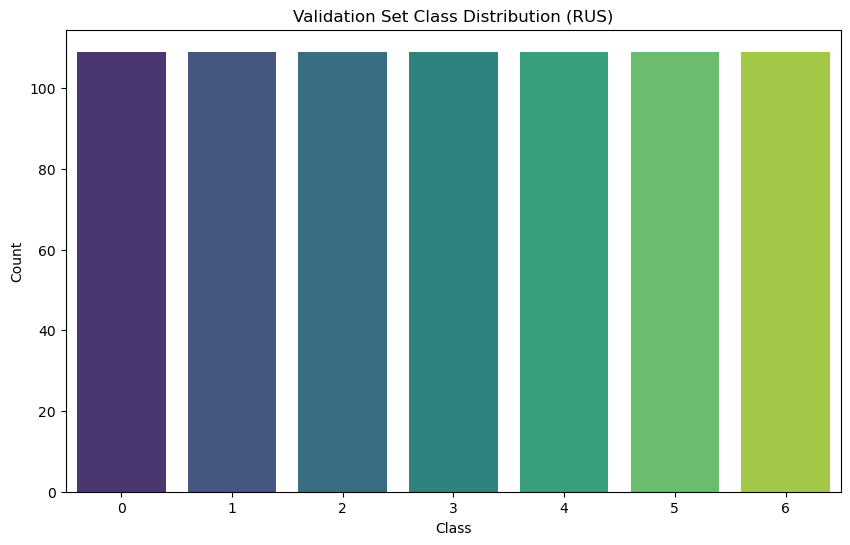

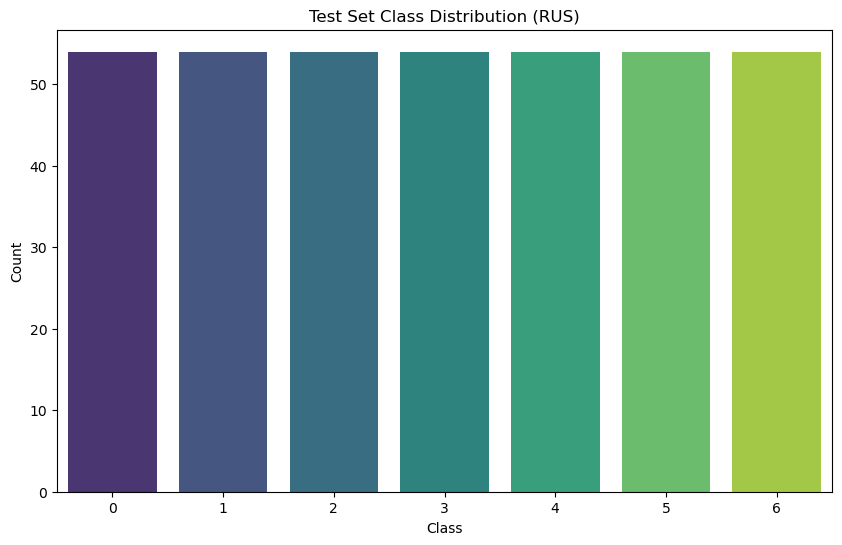

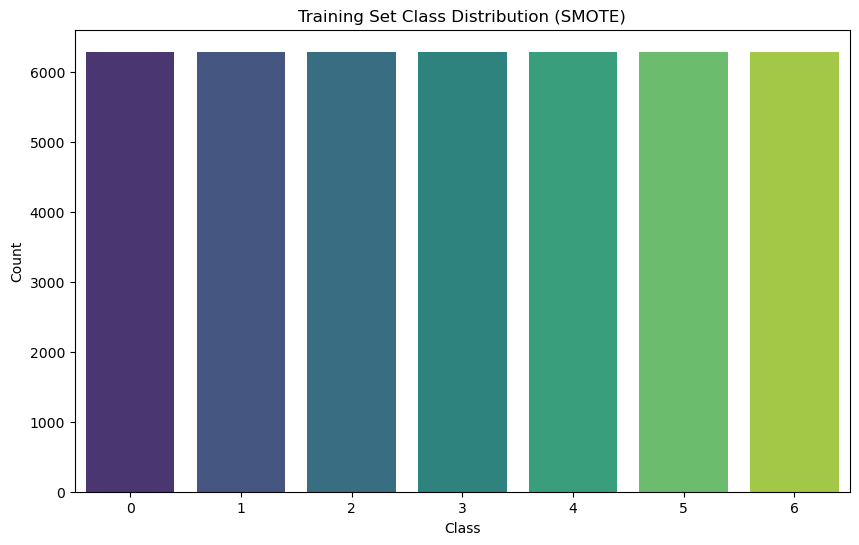

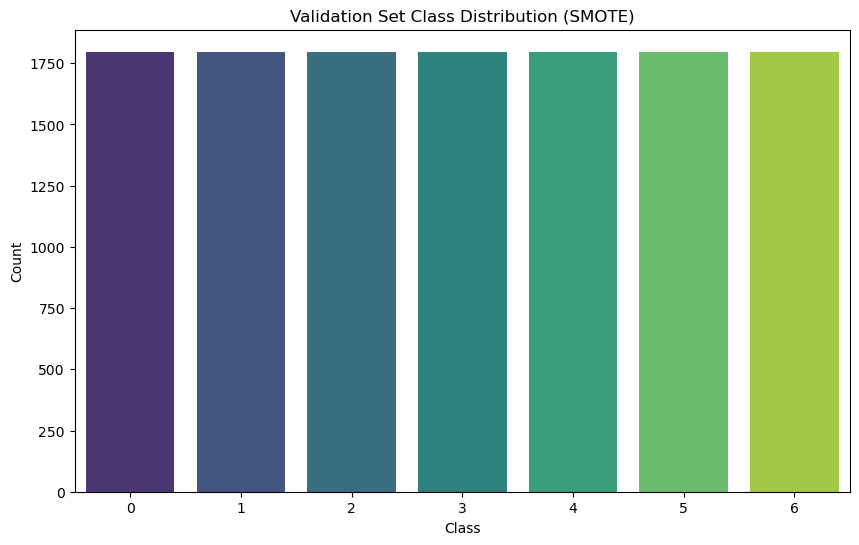

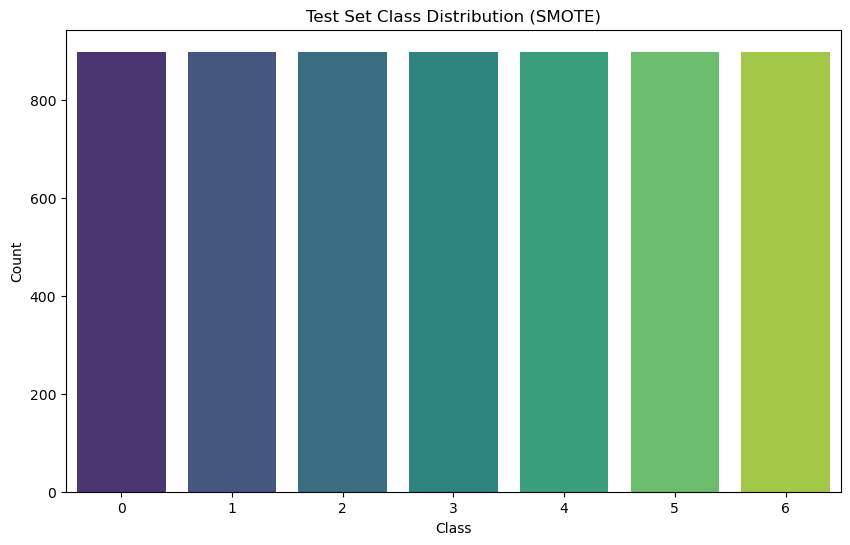

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_distribution(y, title='Class Distribution'):
    """
    Plot the distribution of classes in a dataset.
    
    Parameters:
    y (numpy array): Array of labels in one-hot encoded format.
    title (str): Title for the plot.
    """
    # Convert one-hot encoded labels to class indices
    class_indices = np.argmax(y, axis=1)
    
    # Count occurrences of each class
    unique, counts = np.unique(class_indices, return_counts=True)
    
    # Create a DataFrame for easier plotting with seaborn
    distribution_df = pd.DataFrame({'Class': unique, 'Count': counts})
    
    # Plot the distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Count', data=distribution_df, palette='viridis')
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(ticks=unique)
    plt.show()

# Example usage
plot_class_distribution(y_train_rus, title='Training Set Class Distribution (RUS)')
plot_class_distribution(y_val_rus, title='Validation Set Class Distribution (RUS)')
plot_class_distribution(y_test_rus, title='Test Set Class Distribution (RUS)')

plot_class_distribution(y_train_smote, title='Training Set Class Distribution (SMOTE)')
plot_class_distribution(y_val_smote, title='Validation Set Class Distribution (SMOTE)')
plot_class_distribution(y_test_smote, title='Test Set Class Distribution (SMOTE)')


data generation

In [20]:
datagen_original = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, zoom_range=0.2)
datagen_original.fit(X_train)
valgen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, zoom_range=0.2)
valgen.fit(X_val)

In [21]:
datagen_smote = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, zoom_range=0.2)
datagen_smote.fit(X_train_smote)
valgen_smote=ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, zoom_range=0.2)
valgen_smote.fit(X_val_smote)


In [22]:
datagen_rus = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, zoom_range=0.2)
datagen_rus.fit(X_train_rus)
valgen_rus=ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, zoom_range=0.2)
valgen_rus.fit(X_val_rus)

In [27]:
def cnn_model(optimizer_name, lr=0.0001):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Dense(7, activation='softmax'))

    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(lr=lr)
    elif optimizer_name == 'sgd':
        optimizer = tf.keras.optimizers.SGD(lr=lr)
    else:
        raise ValueError("Unsupported optimizer")

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [22]:
def cnn_model(optimizer_name, lr=0.0001):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Dense(7, activation='softmax'))

    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(lr=lr)
    elif optimizer_name == 'sgd':
        optimizer = tf.keras.optimizers.SGD(lr=lr)
    else:
        raise ValueError("Unsupported optimizer")

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [28]:
def plot_results(history, title_suffix=""):
    plt.plot(history.history["accuracy"], 'r', label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], 'b', label="Validation Accuracy")
    plt.title(f"Model Accuracy {title_suffix}")
    plt.legend()
    plt.show()

    plt.plot(history.history["loss"], 'r', label="Training Loss")
    plt.plot(history.history["val_loss"], 'b', label="Validation Loss")
    plt.title(f"Model Loss {title_suffix}")
    plt.legend()
    plt.show()

In [29]:
def train_and_evaluate_model(model, datagen, X_train, y_train, X_val, y_val, X_test, y_test, optimizer_name, epochs,valgen):

    mlflow.set_experiment("experience 2")
    with mlflow.start_run():
        CLASS_LABELS = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']

        checkpoint_path = f"best_model_{optimizer_name}.h5"
        checkpointer = [EarlyStopping(monitor='val_accuracy', verbose=1, 
                                      restore_best_weights=True, mode="max", patience=5),
                        ModelCheckpoint(checkpoint_path, monitor="val_accuracy", verbose=1,
                                        save_best_only=True, mode="max")]
    
        history = model.fit(datagen.flow(X_train, y_train, batch_size=64), 
                            validation_data=valgen.flow(X_val, y_val), 
                            epochs=epochs, verbose=1)
        plot_results(history, f"with {optimizer_name}")

        # Evaluate on test data
        loss, accuracy = model.evaluate(X_test, y_test)
        print(f"Test Accuracy ({optimizer_name}): {accuracy}")

        # Confusion matrix and classification report
        preds = model.predict(X_test)
        y_pred = np.argmax(preds, axis=1)
        cm_data = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
        cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index=CLASS_LABELS)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix ({optimizer_name})")
        plt.show()

        f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
        print(f"F1 Score ({optimizer_name}): {f1}")

        # Classification report
        print(classification_report(np.argmax(y_test, axis=1), y_pred, digits=3))

        # Log metrics and model with MLflow
        mlflow.log_param("optimizer", optimizer_name)
        mlflow.log_param("batch_size", 64)
        mlflow.log_param("epochs", epochs)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", f1)
        mlflow.tensorflow.log_model(model, "model")


Epoch 1/30
455/455 [==============================] - 31s 50ms/step - loss: 4.0808 - accuracy: 0.2326 - val_loss: 29.5332 - val_accuracy: 0.1285
Epoch 2/30
455/455 [==============================] - 22s 47ms/step - loss: 3.4789 - accuracy: 0.3024 - val_loss: 3.3951 - val_accuracy: 0.2641
Epoch 3/30
455/455 [==============================] - 22s 47ms/step - loss: 2.9935 - accuracy: 0.3406 - val_loss: 3.1905 - val_accuracy: 0.2390
Epoch 4/30
455/455 [==============================] - 22s 47ms/step - loss: 2.5983 - accuracy: 0.3686 - val_loss: 2.3533 - val_accuracy: 0.3994
Epoch 5/30
455/455 [==============================] - 22s 47ms/step - loss: 2.2813 - accuracy: 0.4017 - val_loss: 2.1949 - val_accuracy: 0.4093
Epoch 6/30
455/455 [==============================] - 22s 48ms/step - loss: 2.0433 - accuracy: 0.4317 - val_loss: 2.1359 - val_accuracy: 0.3542
Epoch 7/30
455/455 [==============================] - 22s 48ms/step - loss: 1.8737 - accuracy: 0.4487 - val_loss: 1.8398 - val_accuracy

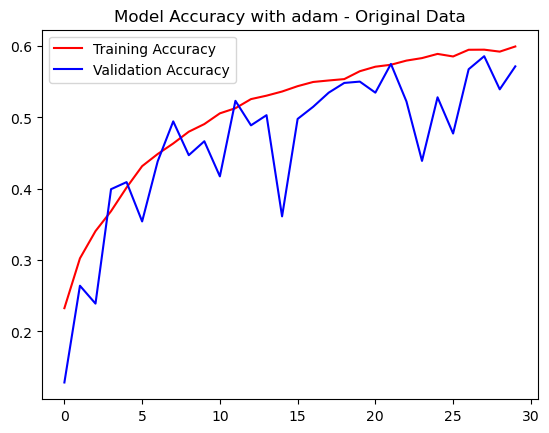

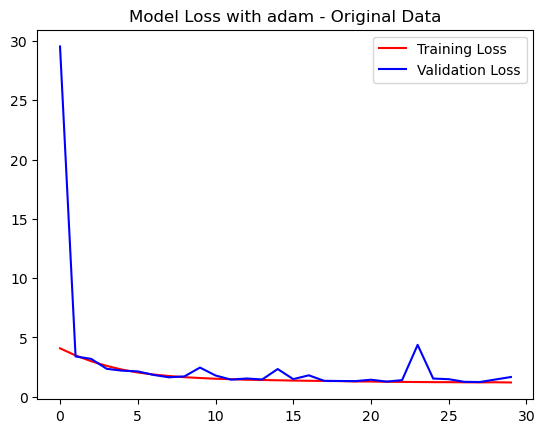

113/113 [==============================] - 1s 8ms/step - loss: 1.8733 - accuracy: 0.5726
Test Accuracy (adam - Original Data): 0.5725829005241394
113/113 [==============================] - 2s 6ms/step


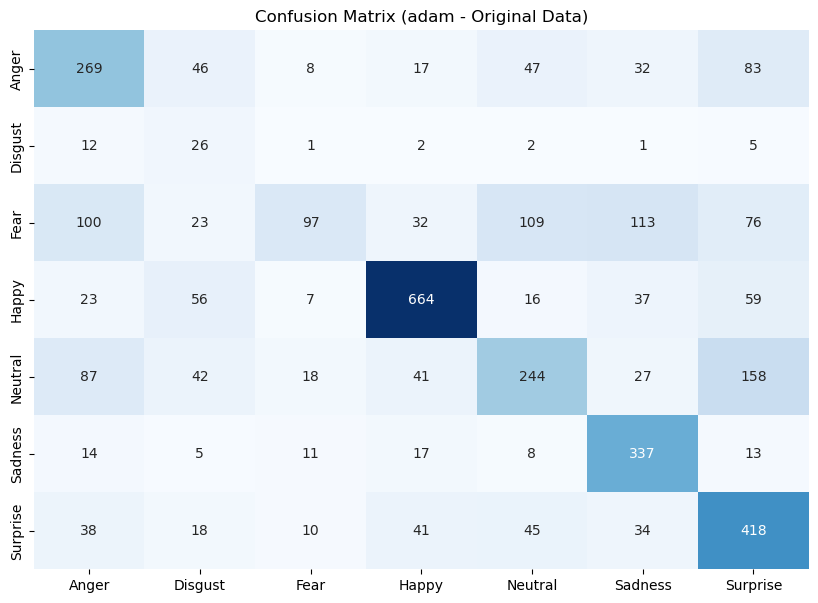

F1 Score (adam - Original Data): 0.560952743018251
              precision    recall  f1-score   support

           0      0.495     0.536     0.515       502
           1      0.120     0.531     0.196        49
           2      0.638     0.176     0.276       550
           3      0.816     0.770     0.792       862
           4      0.518     0.395     0.449       617
           5      0.580     0.832     0.684       405
           6      0.515     0.692     0.590       604

    accuracy                          0.573      3589
   macro avg      0.526     0.562     0.500      3589
weighted avg      0.606     0.573     0.561      3589



2024/09/12 21:46:29 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\amenm\AppData\Local\Temp\tmpny259x5m\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\amenm\AppData\Local\Temp\tmpny259x5m\model\data\model\assets
2024/09/12 21:46:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/12 21:49:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run delightful-owl-812 at: https://dagshub.com/amenallahbenothmen/Emotion_detection_model.mlflow/#/experiments/0/runs/a0f0ea0febe14d6e8c3a8688ff840e67.
2024/09/12 21:49:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/amenallahbenothmen/Emotion_detection_model.mlflow/#/experiments/0.


Epoch 1/50
455/455 [==============================] - 23s 49ms/step - loss: 4.0694 - accuracy: 0.2350 - val_loss: 26.2168 - val_accuracy: 0.1647
Epoch 2/50
455/455 [==============================] - 22s 48ms/step - loss: 3.4717 - accuracy: 0.2895 - val_loss: 3.6209 - val_accuracy: 0.2851
Epoch 3/50
455/455 [==============================] - 22s 48ms/step - loss: 2.9814 - accuracy: 0.3253 - val_loss: 2.7325 - val_accuracy: 0.3486
Epoch 4/50
455/455 [==============================] - 22s 48ms/step - loss: 2.5679 - accuracy: 0.3662 - val_loss: 2.3900 - val_accuracy: 0.3480
Epoch 5/50
455/455 [==============================] - 22s 48ms/step - loss: 2.2505 - accuracy: 0.3921 - val_loss: 2.1134 - val_accuracy: 0.3873
Epoch 6/50
455/455 [==============================] - 22s 48ms/step - loss: 2.0155 - accuracy: 0.4167 - val_loss: 1.9333 - val_accuracy: 0.4359
Epoch 7/50
455/455 [==============================] - 22s 48ms/step - loss: 1.8455 - accuracy: 0.4434 - val_loss: 1.6463 - val_accuracy

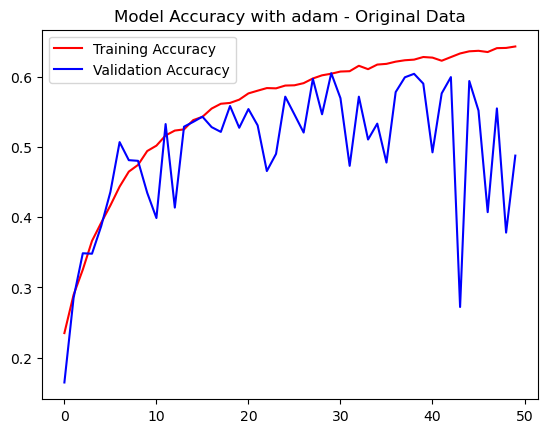

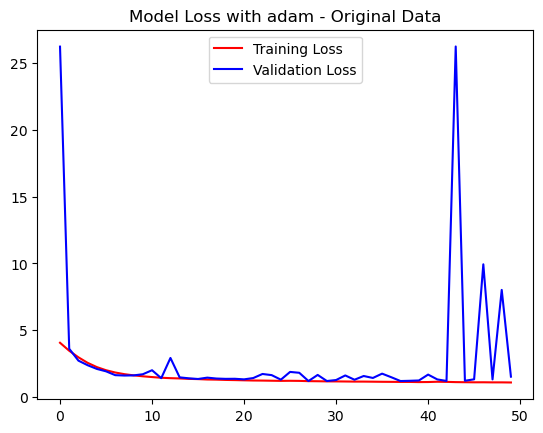

113/113 [==============================] - 1s 7ms/step - loss: 1.4476 - accuracy: 0.5366
Test Accuracy (adam - Original Data): 0.5366397500038147
113/113 [==============================] - 1s 5ms/step


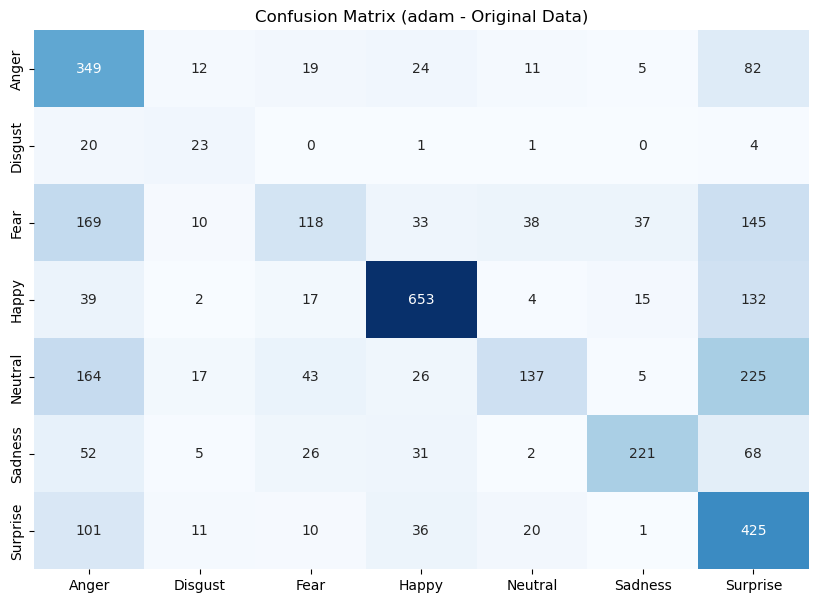

F1 Score (adam - Original Data): 0.5233109825130053
              precision    recall  f1-score   support

           0      0.390     0.695     0.500       502
           1      0.287     0.469     0.357        49
           2      0.506     0.215     0.301       550
           3      0.812     0.758     0.784       862
           4      0.643     0.222     0.330       617
           5      0.778     0.546     0.642       405
           6      0.393     0.704     0.504       604

    accuracy                          0.537      3589
   macro avg      0.544     0.515     0.488      3589
weighted avg      0.596     0.537     0.523      3589



2024/09/12 22:07:13 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\amenm\AppData\Local\Temp\tmpog9idnit\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\amenm\AppData\Local\Temp\tmpog9idnit\model\data\model\assets
2024/09/12 22:07:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/12 22:09:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run sassy-shrimp-807 at: https://dagshub.com/amenallahbenothmen/Emotion_detection_model.mlflow/#/experiments/0/runs/1dcd2401131b44fa887053621829a9ef.
2024/09/12 22:09:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/amenallahbenothmen/Emotion_detection_model.mlflow/#/experiments/0.


Epoch 1/100
455/455 [==============================] - 22s 48ms/step - loss: 4.0755 - accuracy: 0.2358 - val_loss: 7.0386 - val_accuracy: 0.2582
Epoch 2/100
455/455 [==============================] - 22s 48ms/step - loss: 3.4736 - accuracy: 0.2896 - val_loss: 3.1483 - val_accuracy: 0.3350
Epoch 3/100
455/455 [==============================] - 22s 48ms/step - loss: 2.9790 - accuracy: 0.3332 - val_loss: 2.6602 - val_accuracy: 0.3666
Epoch 4/100
455/455 [==============================] - 22s 48ms/step - loss: 2.5595 - accuracy: 0.3704 - val_loss: 2.2477 - val_accuracy: 0.4303
Epoch 5/100
455/455 [==============================] - 22s 48ms/step - loss: 2.2542 - accuracy: 0.3935 - val_loss: 2.0296 - val_accuracy: 0.4347
Epoch 6/100
455/455 [==============================] - 22s 48ms/step - loss: 2.0175 - accuracy: 0.4232 - val_loss: 1.8431 - val_accuracy: 0.4591
Epoch 7/100
455/455 [==============================] - 22s 48ms/step - loss: 1.8544 - accuracy: 0.4464 - val_loss: 2.0373 - val_ac

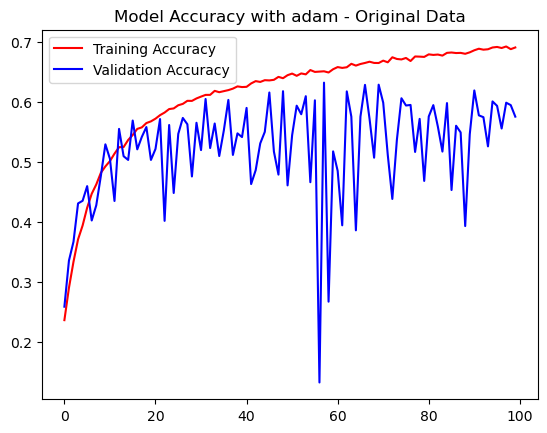

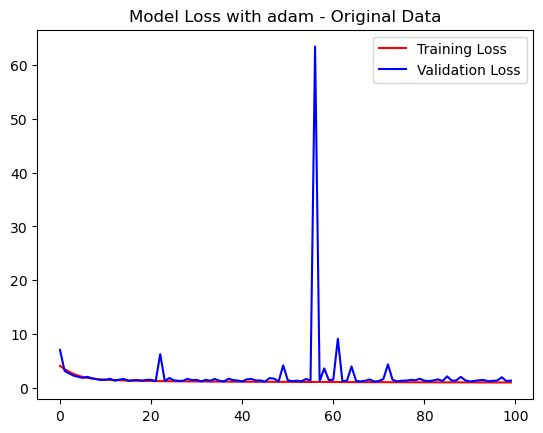

113/113 [==============================] - 1s 6ms/step - loss: 1.2201 - accuracy: 0.6144
Test Accuracy (adam - Original Data): 0.6143772602081299
113/113 [==============================] - 1s 5ms/step


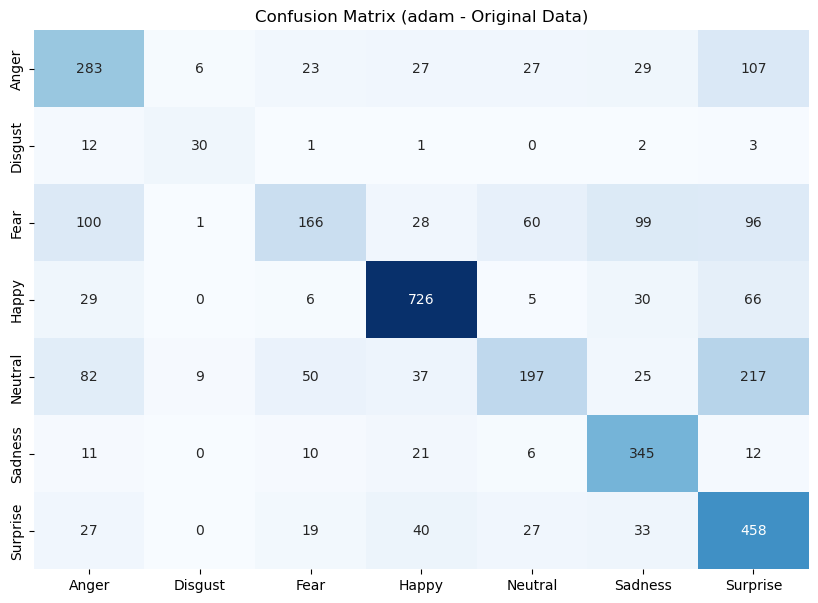

F1 Score (adam - Original Data): 0.597372444699093
              precision    recall  f1-score   support

           0      0.520     0.564     0.541       502
           1      0.652     0.612     0.632        49
           2      0.604     0.302     0.402       550
           3      0.825     0.842     0.834       862
           4      0.612     0.319     0.420       617
           5      0.613     0.852     0.713       405
           6      0.478     0.758     0.586       604

    accuracy                          0.614      3589
   macro avg      0.615     0.607     0.590      3589
weighted avg      0.627     0.614     0.597      3589



2024/09/12 22:45:55 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\amenm\AppData\Local\Temp\tmpo38ih51j\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\amenm\AppData\Local\Temp\tmpo38ih51j\model\data\model\assets
2024/09/12 22:46:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/12 22:48:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run thoughtful-mole-705 at: https://dagshub.com/amenallahbenothmen/Emotion_detection_model.mlflow/#/experiments/0/runs/50385809e5f14bc5b0a92fa843c6de55.
2024/09/12 22:48:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/amenallahbenothmen/Emotion_detection_model.mlflow/#/experiments/0.


Epoch 1/30
455/455 [==============================] - 23s 48ms/step - loss: 4.7529 - accuracy: 0.1577 - val_loss: 4.8030 - val_accuracy: 0.0149
Epoch 2/30
455/455 [==============================] - 21s 47ms/step - loss: 4.7162 - accuracy: 0.1619 - val_loss: 4.4972 - val_accuracy: 0.1721
Epoch 3/30
455/455 [==============================] - 21s 47ms/step - loss: 4.6470 - accuracy: 0.1676 - val_loss: 4.2307 - val_accuracy: 0.1981
Epoch 4/30
455/455 [==============================] - 21s 47ms/step - loss: 4.5429 - accuracy: 0.1800 - val_loss: 4.1580 - val_accuracy: 0.1786
Epoch 5/30
455/455 [==============================] - 21s 47ms/step - loss: 4.4860 - accuracy: 0.1904 - val_loss: 3.9539 - val_accuracy: 0.2669
Epoch 6/30
455/455 [==============================] - 21s 47ms/step - loss: 4.4334 - accuracy: 0.1969 - val_loss: 4.0914 - val_accuracy: 0.1793
Epoch 7/30
455/455 [==============================] - 21s 47ms/step - loss: 4.4080 - accuracy: 0.2002 - val_loss: 4.4103 - val_accuracy:

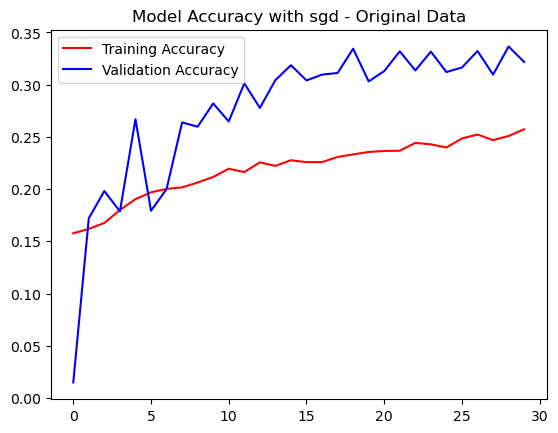

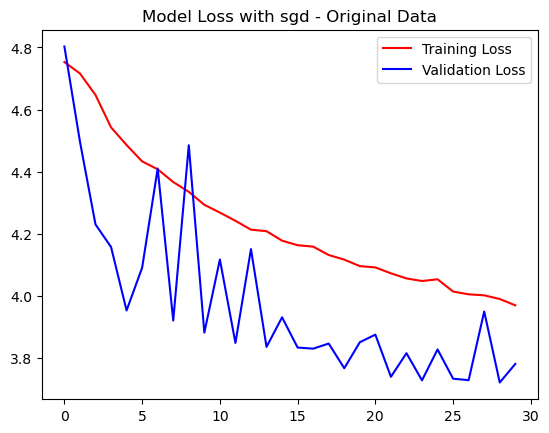

113/113 [==============================] - 1s 7ms/step - loss: 3.7409 - accuracy: 0.3380
Test Accuracy (sgd - Original Data): 0.3379771411418915
113/113 [==============================] - 1s 5ms/step


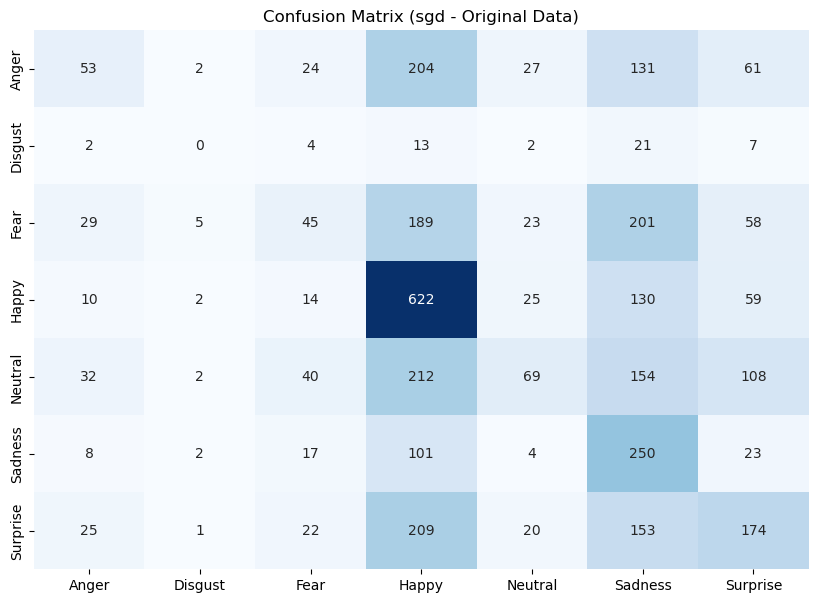

F1 Score (sgd - Original Data): 0.28829128204080195
              precision    recall  f1-score   support

           0      0.333     0.106     0.160       502
           1      0.000     0.000     0.000        49
           2      0.271     0.082     0.126       550
           3      0.401     0.722     0.516       862
           4      0.406     0.112     0.175       617
           5      0.240     0.617     0.346       405
           6      0.355     0.288     0.318       604

    accuracy                          0.338      3589
   macro avg      0.287     0.275     0.234      3589
weighted avg      0.341     0.338     0.288      3589



2024/09/12 22:59:14 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\amenm\AppData\Local\Temp\tmp2_gjlk5s\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\amenm\AppData\Local\Temp\tmp2_gjlk5s\model\data\model\assets
2024/09/12 22:59:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/12 23:00:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run carefree-ant-511 at: https://dagshub.com/amenallahbenothmen/Emotion_detection_model.mlflow/#/experiments/0/runs/dc08361284f54415a1251989138fd927.
2024/09/12 23:00:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/amenallahbenothmen/Emotion_detection_model.mlflow/#/experiments/0.


Epoch 1/50
455/455 [==============================] - 22s 47ms/step - loss: 4.7418 - accuracy: 0.1609 - val_loss: 5.3175 - val_accuracy: 0.1192
Epoch 2/50
455/455 [==============================] - 21s 47ms/step - loss: 4.6179 - accuracy: 0.1775 - val_loss: 4.2312 - val_accuracy: 0.1632
Epoch 3/50
455/455 [==============================] - 21s 47ms/step - loss: 4.5717 - accuracy: 0.1805 - val_loss: 4.1220 - val_accuracy: 0.1542
Epoch 4/50
455/455 [==============================] - 21s 47ms/step - loss: 4.5119 - accuracy: 0.1887 - val_loss: 4.0642 - val_accuracy: 0.2300
Epoch 5/50
455/455 [==============================] - 21s 47ms/step - loss: 4.4326 - accuracy: 0.2026 - val_loss: 4.3897 - val_accuracy: 0.2254
Epoch 6/50
455/455 [==============================] - 21s 47ms/step - loss: 4.4109 - accuracy: 0.2021 - val_loss: 4.1403 - val_accuracy: 0.1985
Epoch 7/50
455/455 [==============================] - 21s 47ms/step - loss: 4.3589 - accuracy: 0.2071 - val_loss: 4.0059 - val_accuracy:

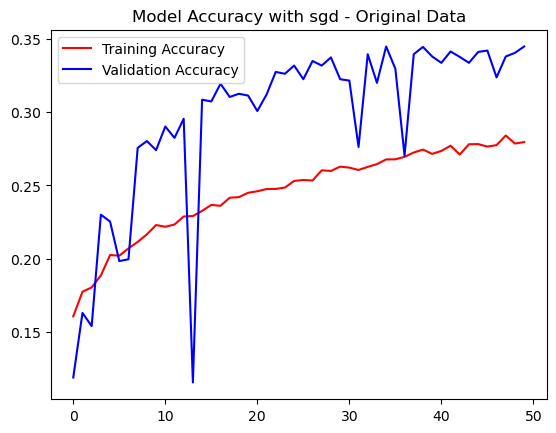

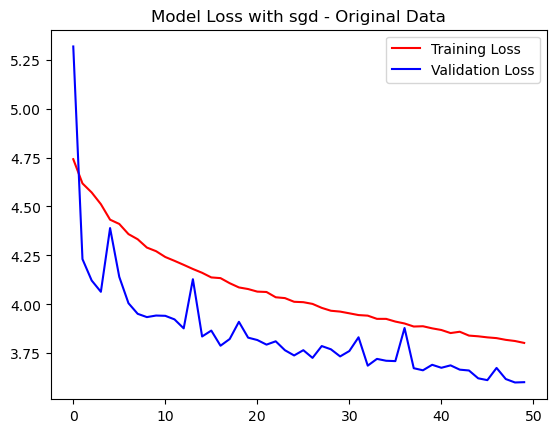

113/113 [==============================] - 1s 6ms/step - loss: 3.5806 - accuracy: 0.3508
Test Accuracy (sgd - Original Data): 0.35079410672187805
113/113 [==============================] - 1s 5ms/step


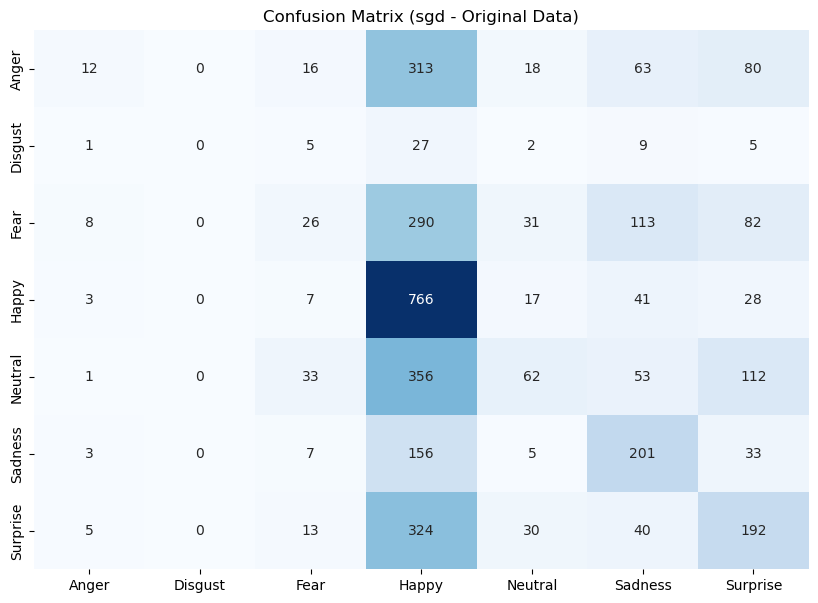

F1 Score (sgd - Original Data): 0.27051766909905944
              precision    recall  f1-score   support

           0      0.364     0.024     0.045       502
           1      0.000     0.000     0.000        49
           2      0.243     0.047     0.079       550
           3      0.343     0.889     0.495       862
           4      0.376     0.100     0.159       617
           5      0.387     0.496     0.435       405
           6      0.361     0.318     0.338       604

    accuracy                          0.351      3589
   macro avg      0.296     0.268     0.221      3589
weighted avg      0.339     0.351     0.271      3589



2024/09/12 23:18:06 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\amenm\AppData\Local\Temp\tmp8qxibpbt\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\amenm\AppData\Local\Temp\tmp8qxibpbt\model\data\model\assets
2024/09/12 23:18:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/12 23:19:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run handsome-sponge-377 at: https://dagshub.com/amenallahbenothmen/Emotion_detection_model.mlflow/#/experiments/0/runs/74f9f349cbf44e1ebc11f098263c35d7.
2024/09/12 23:19:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/amenallahbenothmen/Emotion_detection_model.mlflow/#/experiments/0.


Epoch 1/100
455/455 [==============================] - 22s 47ms/step - loss: 4.7449 - accuracy: 0.1522 - val_loss: 4.9305 - val_accuracy: 0.1647
Epoch 2/100
455/455 [==============================] - 21s 46ms/step - loss: 4.6510 - accuracy: 0.1669 - val_loss: 4.7012 - val_accuracy: 0.2433
Epoch 3/100
455/455 [==============================] - 21s 46ms/step - loss: 4.5439 - accuracy: 0.1827 - val_loss: 3.9930 - val_accuracy: 0.2498
Epoch 4/100
455/455 [==============================] - 21s 47ms/step - loss: 4.5093 - accuracy: 0.1871 - val_loss: 4.1494 - val_accuracy: 0.1656
Epoch 5/100
455/455 [==============================] - 21s 47ms/step - loss: 4.4628 - accuracy: 0.1940 - val_loss: 4.1029 - val_accuracy: 0.2111
Epoch 6/100
455/455 [==============================] - 21s 47ms/step - loss: 4.4245 - accuracy: 0.2006 - val_loss: 4.0099 - val_accuracy: 0.2743
Epoch 7/100
455/455 [==============================] - 21s 47ms/step - loss: 4.3878 - accuracy: 0.2057 - val_loss: 4.0036 - val_ac

2024/09/12 23:24:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run secretive-wren-532 at: https://dagshub.com/amenallahbenothmen/Emotion_detection_model.mlflow/#/experiments/0/runs/f1d61e4cc1a343e2a3988a0b5f3a9806.
2024/09/12 23:24:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/amenallahbenothmen/Emotion_detection_model.mlflow/#/experiments/0.


KeyboardInterrupt: 

In [44]:
optimizers = ['adam', 'sgd']
epochs_list = [30, 50, 100]

# Original Data
for optimizer in optimizers:
    for epochs in epochs_list:
        model = cnn_model(optimizer)
        train_and_evaluate_model(model, datagen=datagen_original, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, X_test=X_test, y_test=y_test, optimizer_name=f"{optimizer} - Original Data", epochs=epochs, valgen=valgen)

Epoch 1/100
455/455 [==============================] - 31s 50ms/step - loss: 4.8241 - accuracy: 0.1489 - val_loss: 4.5303 - val_accuracy: 0.1096
Epoch 2/100
455/455 [==============================] - 22s 49ms/step - loss: 4.6997 - accuracy: 0.1622 - val_loss: 5.1319 - val_accuracy: 0.1093
Epoch 3/100
455/455 [==============================] - 23s 50ms/step - loss: 4.6415 - accuracy: 0.1606 - val_loss: 4.1775 - val_accuracy: 0.2223
Epoch 4/100
455/455 [==============================] - 22s 48ms/step - loss: 4.5590 - accuracy: 0.1747 - val_loss: 4.3630 - val_accuracy: 0.1622
Epoch 5/100
455/455 [==============================] - 22s 48ms/step - loss: 4.4823 - accuracy: 0.1913 - val_loss: 4.0123 - val_accuracy: 0.2437
Epoch 6/100
455/455 [==============================] - 22s 49ms/step - loss: 4.4379 - accuracy: 0.1917 - val_loss: 4.1970 - val_accuracy: 0.2452
Epoch 7/100
455/455 [==============================] - 22s 48ms/step - loss: 4.3945 - accuracy: 0.1987 - val_loss: 3.9543 - val_ac

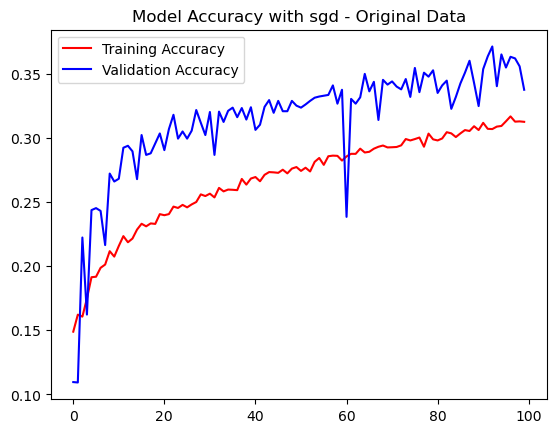

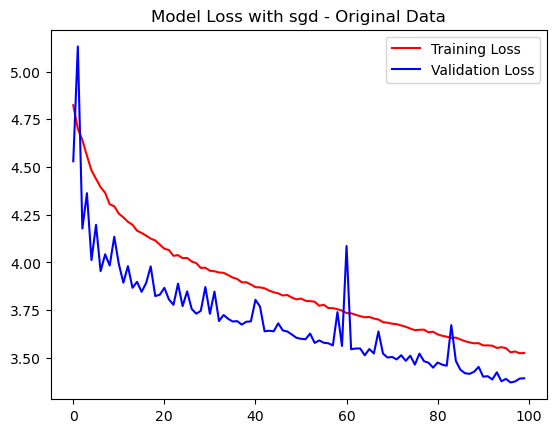

113/113 [==============================] - 1s 7ms/step - loss: 3.3404 - accuracy: 0.3742
Test Accuracy (sgd - Original Data): 0.37419894337654114
113/113 [==============================] - 1s 5ms/step


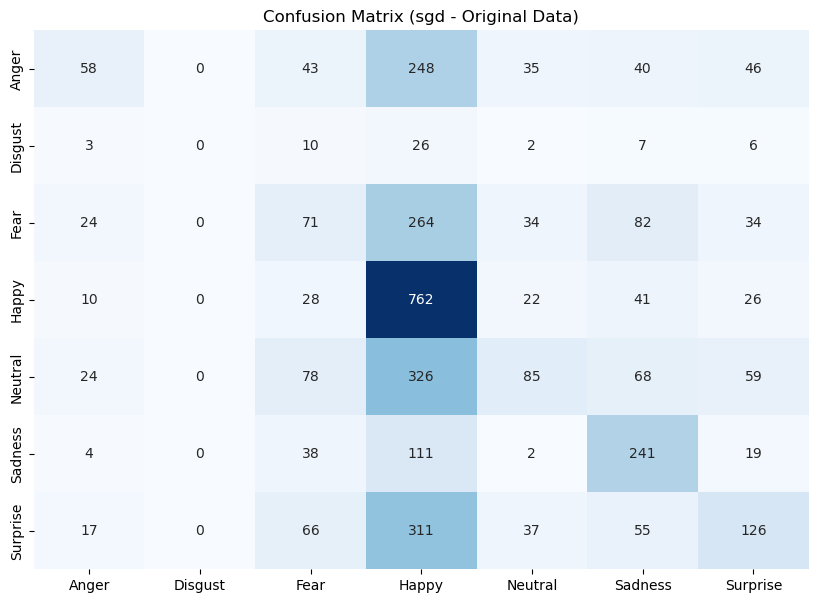

F1 Score (sgd - Original Data): 0.317731757373464
              precision    recall  f1-score   support

           0      0.414     0.123     0.190       470
           1      0.000     0.000     0.000        54
           2      0.213     0.139     0.168       509
           3      0.372     0.857     0.519       889
           4      0.392     0.133     0.198       640
           5      0.451     0.581     0.508       415
           6      0.399     0.206     0.272       612

    accuracy                          0.374      3589
   macro avg      0.320     0.291     0.265      3589
weighted avg      0.367     0.374     0.318      3589



2024/09/13 17:16:57 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\amenm\AppData\Local\Temp\tmpug9oha_j\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\amenm\AppData\Local\Temp\tmpug9oha_j\model\data\model\assets
2024/09/13 17:17:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/13 17:18:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-flea-930 at: https://dagshub.com/amenallahbenothmen/Emotion_detection_model.mlflow/#/experiments/0/runs/1912f2a4dd5b41fa877b8fac5772aa4e.
2024/09/13 17:18:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/amenallahbenothmen/Emotion_detection_model.mlflow/#/experiments/0.


In [20]:
model = cnn_model('sgd')
train_and_evaluate_model(model, datagen=datagen_original, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, X_test=X_test, y_test=y_test, optimizer_name="sgd - Original Data", epochs=100, valgen=valgen)


In [30]:
epochs_list = [50]
optimizers = ['adam', 'sgd']

Epoch 1/50
689/689 [==============================] - 28s 39ms/step - loss: 2.0900 - accuracy: 0.2439 - val_loss: 1.8875 - val_accuracy: 0.2583
Epoch 2/50
689/689 [==============================] - 26s 38ms/step - loss: 1.8768 - accuracy: 0.3069 - val_loss: 1.9791 - val_accuracy: 0.2763
Epoch 3/50
689/689 [==============================] - 26s 38ms/step - loss: 1.7273 - accuracy: 0.3662 - val_loss: 1.6983 - val_accuracy: 0.3485
Epoch 4/50
689/689 [==============================] - 26s 38ms/step - loss: 1.6202 - accuracy: 0.4025 - val_loss: 1.5276 - val_accuracy: 0.4349
Epoch 5/50
689/689 [==============================] - 26s 38ms/step - loss: 1.5379 - accuracy: 0.4322 - val_loss: 1.8146 - val_accuracy: 0.3236
Epoch 6/50
689/689 [==============================] - 26s 38ms/step - loss: 1.4573 - accuracy: 0.4591 - val_loss: 1.4689 - val_accuracy: 0.4529
Epoch 7/50
689/689 [==============================] - 26s 38ms/step - loss: 1.4038 - accuracy: 0.4782 - val_loss: 1.5623 - val_accuracy:

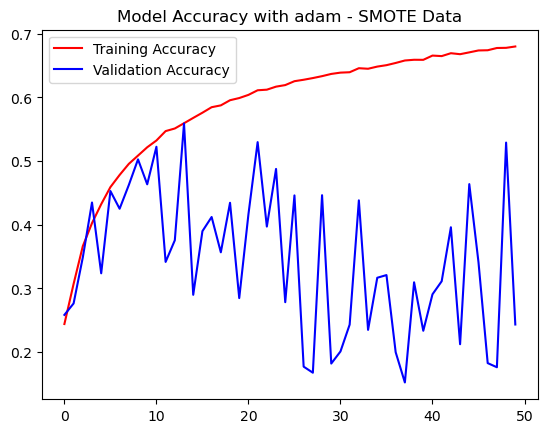

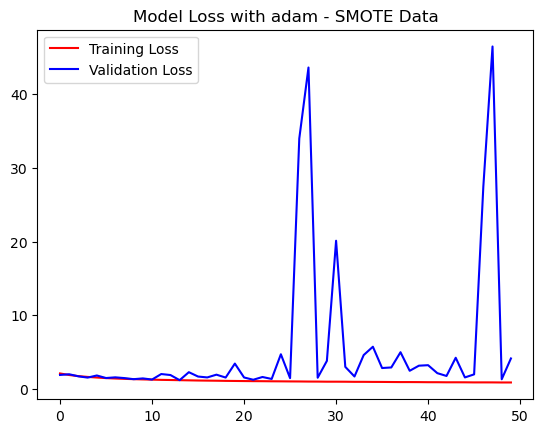

197/197 [==============================] - 1s 6ms/step - loss: 3.8010 - accuracy: 0.2846
Test Accuracy (adam - SMOTE Data): 0.28460070490837097
197/197 [==============================] - 1s 4ms/step


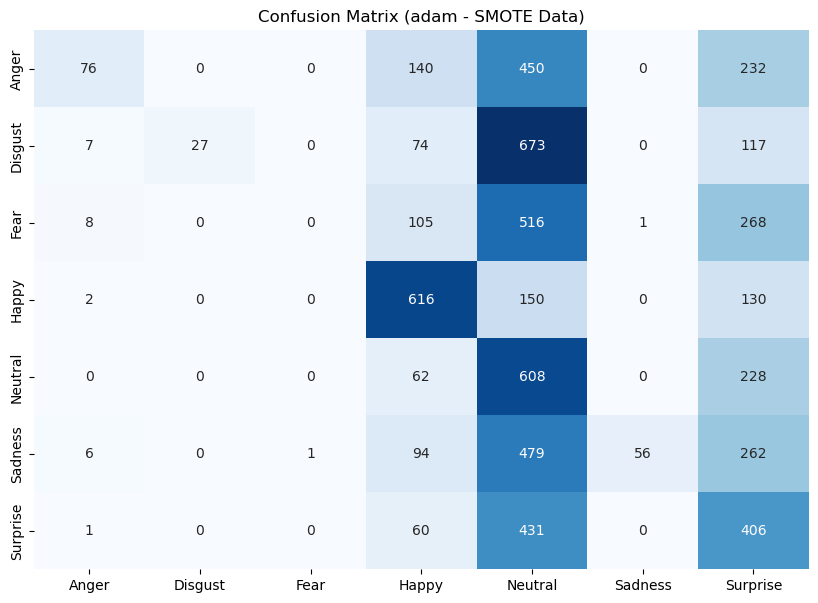

F1 Score (adam - SMOTE Data): 0.2197097375684472
              precision    recall  f1-score   support

           0      0.760     0.085     0.152       898
           1      1.000     0.030     0.058       898
           2      0.000     0.000     0.000       898
           3      0.535     0.686     0.601       898
           4      0.184     0.677     0.289       898
           5      0.982     0.062     0.117       898
           6      0.247     0.452     0.320       898

    accuracy                          0.285      6286
   macro avg      0.530     0.285     0.220      6286
weighted avg      0.530     0.285     0.220      6286



2024/09/17 12:52:16 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\amenm\AppData\Local\Temp\tmpo1gcl7sx\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\amenm\AppData\Local\Temp\tmpo1gcl7sx\model\data\model\assets
2024/09/17 12:52:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/17 12:54:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run lyrical-hound-4 at: https://dagshub.com/amenallahbenothmen/Emotion_detection_model.mlflow/#/experiments/1/runs/516af1618a604538982aa772cae195bd.
2024/09/17 12:54:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/amenallahbenothmen/Emotion_detection_model.mlflow/#/experiments/1.


Epoch 1/50
689/689 [==============================] - 27s 38ms/step - loss: 2.6335 - accuracy: 0.1605 - val_loss: 2.3234 - val_accuracy: 0.1514
Epoch 2/50
689/689 [==============================] - 26s 38ms/step - loss: 2.4574 - accuracy: 0.1847 - val_loss: 2.6409 - val_accuracy: 0.1735
Epoch 3/50
689/689 [==============================] - 26s 37ms/step - loss: 2.3851 - accuracy: 0.1948 - val_loss: 2.1001 - val_accuracy: 0.2105
Epoch 4/50
689/689 [==============================] - 26s 38ms/step - loss: 2.3064 - accuracy: 0.2075 - val_loss: 1.9698 - val_accuracy: 0.2425
Epoch 5/50
689/689 [==============================] - 26s 38ms/step - loss: 2.2505 - accuracy: 0.2140 - val_loss: 2.4201 - val_accuracy: 0.1872
Epoch 6/50
689/689 [==============================] - 26s 38ms/step - loss: 2.2217 - accuracy: 0.2183 - val_loss: 2.0062 - val_accuracy: 0.2319
Epoch 7/50
689/689 [==============================] - 26s 38ms/step - loss: 2.1956 - accuracy: 0.2248 - val_loss: 2.2736 - val_accuracy:

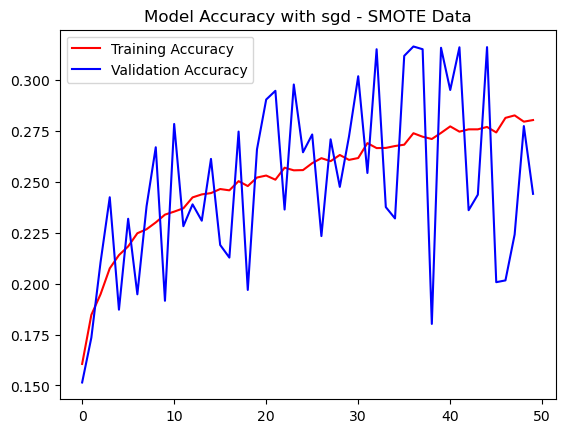

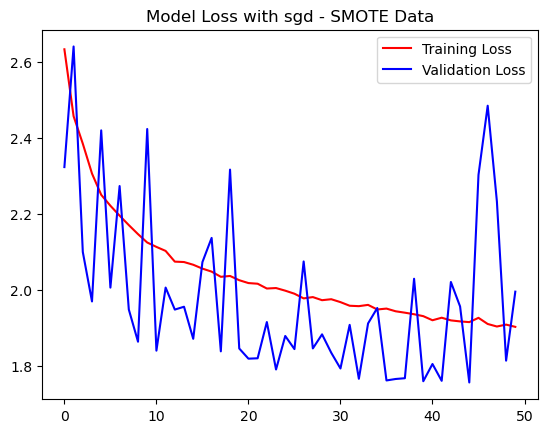

197/197 [==============================] - 2s 10ms/step - loss: 1.8372 - accuracy: 0.2997
Test Accuracy (sgd - SMOTE Data): 0.2997136414051056
197/197 [==============================] - 1s 6ms/step


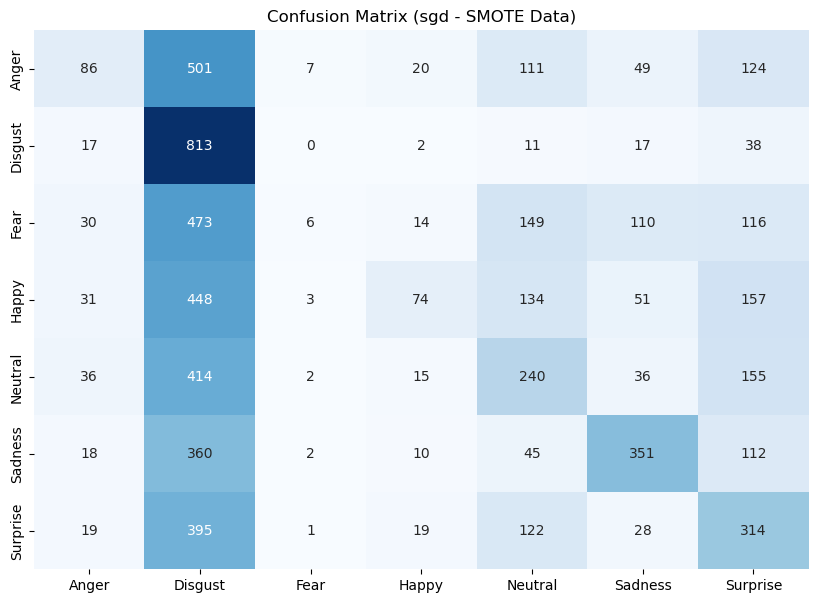

F1 Score (sgd - SMOTE Data): 0.24970032188733468
              precision    recall  f1-score   support

           0      0.363     0.096     0.152       898
           1      0.239     0.905     0.378       898
           2      0.286     0.007     0.013       898
           3      0.481     0.082     0.141       898
           4      0.296     0.267     0.281       898
           5      0.547     0.391     0.456       898
           6      0.309     0.350     0.328       898

    accuracy                          0.300      6286
   macro avg      0.360     0.300     0.250      6286
weighted avg      0.360     0.300     0.250      6286



2024/09/17 13:17:06 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\amenm\AppData\Local\Temp\tmpd2a87c5j\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\amenm\AppData\Local\Temp\tmpd2a87c5j\model\data\model\assets
2024/09/17 13:17:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/17 13:18:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run popular-moth-310 at: https://dagshub.com/amenallahbenothmen/Emotion_detection_model.mlflow/#/experiments/1/runs/40094903994a4408b88dd29b937a9f95.
2024/09/17 13:18:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/amenallahbenothmen/Emotion_detection_model.mlflow/#/experiments/1.


In [31]:
for optimizer in optimizers:
    for epochs in epochs_list:
        model = cnn_model(optimizer)
        train_and_evaluate_model(model, datagen=datagen_smote, X_train=X_train_smote, y_train=y_train_smote, X_val=X_val_smote, y_val=y_val_smote, X_test=X_test_smote, y_test=y_test_smote, optimizer_name=f"{optimizer} - SMOTE Data", epochs=epochs, valgen=valgen_smote)

In [30]:
epochs_list = [50]
optimizers = ['adam', 'sgd']

Epoch 1/50
48/48 [==============================] - 6s 99ms/step - loss: 4.5995 - accuracy: 0.1880 - val_loss: 4.0288 - val_accuracy: 0.1429
Epoch 2/50
48/48 [==============================] - 2s 50ms/step - loss: 4.2728 - accuracy: 0.2154 - val_loss: 4.0385 - val_accuracy: 0.1429
Epoch 3/50
48/48 [==============================] - 3s 53ms/step - loss: 4.1661 - accuracy: 0.2295 - val_loss: 4.3479 - val_accuracy: 0.1429
Epoch 4/50
48/48 [==============================] - 2s 52ms/step - loss: 4.0880 - accuracy: 0.2337 - val_loss: 5.7835 - val_accuracy: 0.1429
Epoch 5/50
48/48 [==============================] - 2s 51ms/step - loss: 4.0044 - accuracy: 0.2396 - val_loss: 8.2772 - val_accuracy: 0.1429
Epoch 6/50
48/48 [==============================] - 2s 50ms/step - loss: 3.9601 - accuracy: 0.2449 - val_loss: 10.5158 - val_accuracy: 0.1429
Epoch 7/50
48/48 [==============================] - 2s 49ms/step - loss: 3.9194 - accuracy: 0.2491 - val_loss: 12.2061 - val_accuracy: 0.1429
Epoch 8/50


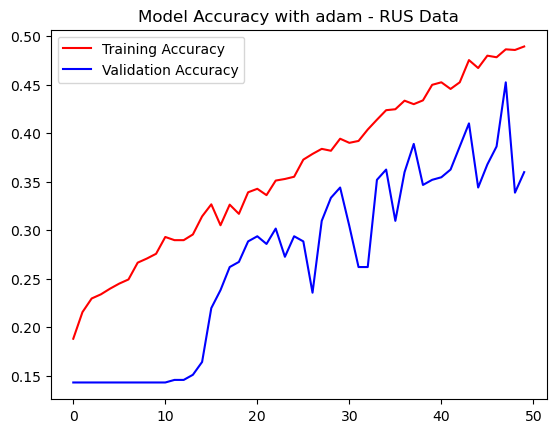

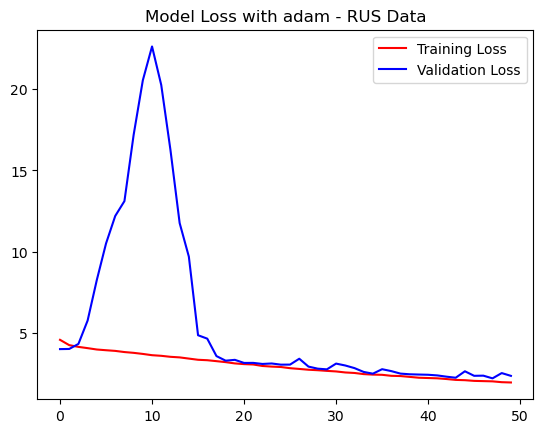

12/12 [==============================] - 0s 28ms/step - loss: 2.3047 - accuracy: 0.4153
Test Accuracy (adam - RUS Data): 0.41534391045570374
12/12 [==============================] - 0s 5ms/step


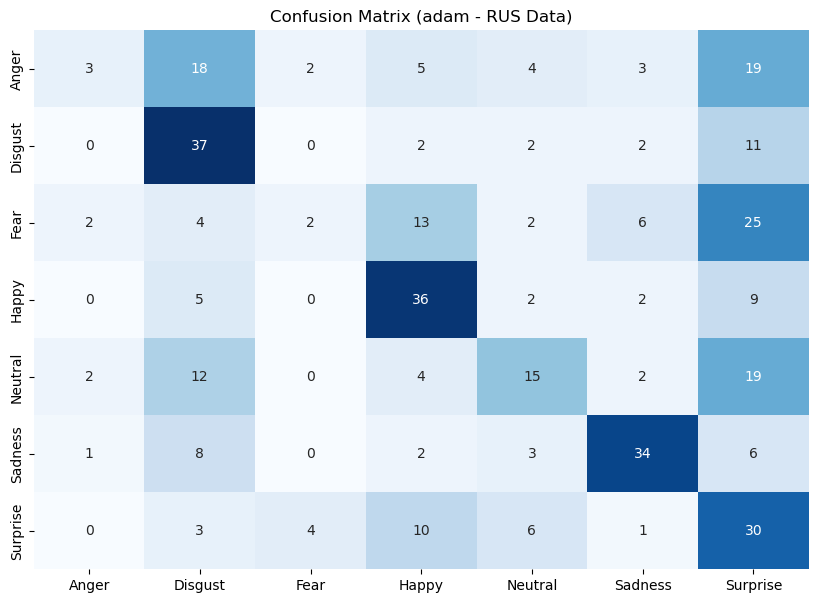

F1 Score (adam - RUS Data): 0.3713025204354968
              precision    recall  f1-score   support

           0      0.375     0.056     0.097        54
           1      0.425     0.685     0.525        54
           2      0.250     0.037     0.065        54
           3      0.500     0.667     0.571        54
           4      0.441     0.278     0.341        54
           5      0.680     0.630     0.654        54
           6      0.252     0.556     0.347        54

    accuracy                          0.415       378
   macro avg      0.418     0.415     0.371       378
weighted avg      0.418     0.415     0.371       378



2024/09/14 20:36:10 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\amenm\AppData\Local\Temp\tmp5d4yq4rv\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\amenm\AppData\Local\Temp\tmp5d4yq4rv\model\data\model\assets
2024/09/14 20:36:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/14 20:38:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run likeable-skunk-431 at: https://dagshub.com/amenallahbenothmen/Emotion_detection_model.mlflow/#/experiments/1/runs/52d3969976cb4092ae51a97237a70fa1.
2024/09/14 20:38:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/amenallahbenothmen/Emotion_detection_model.mlflow/#/experiments/1.


Epoch 1/50
48/48 [==============================] - 5s 78ms/step - loss: 4.9007 - accuracy: 0.1383 - val_loss: 4.0864 - val_accuracy: 0.1429
Epoch 2/50
48/48 [==============================] - 4s 74ms/step - loss: 4.8839 - accuracy: 0.1402 - val_loss: 4.2043 - val_accuracy: 0.1429
Epoch 3/50
48/48 [==============================] - 3s 58ms/step - loss: 4.8368 - accuracy: 0.1487 - val_loss: 4.2360 - val_accuracy: 0.1429
Epoch 4/50
48/48 [==============================] - 3s 55ms/step - loss: 4.8428 - accuracy: 0.1445 - val_loss: 4.2235 - val_accuracy: 0.1429
Epoch 5/50
48/48 [==============================] - 3s 61ms/step - loss: 4.7741 - accuracy: 0.1579 - val_loss: 4.1955 - val_accuracy: 0.1429
Epoch 6/50
48/48 [==============================] - 3s 61ms/step - loss: 4.7443 - accuracy: 0.1559 - val_loss: 4.2001 - val_accuracy: 0.1481
Epoch 7/50
48/48 [==============================] - 3s 58ms/step - loss: 4.7834 - accuracy: 0.1546 - val_loss: 4.2341 - val_accuracy: 0.1429
Epoch 8/50
48

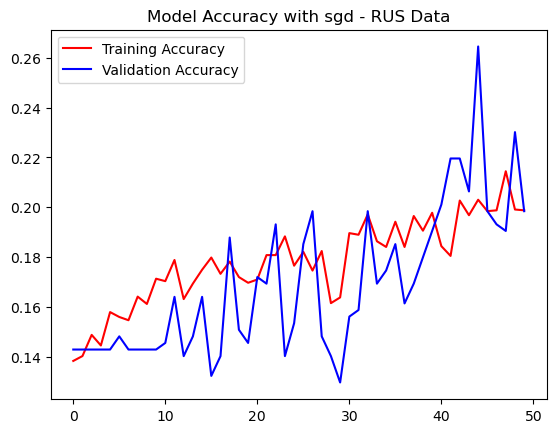

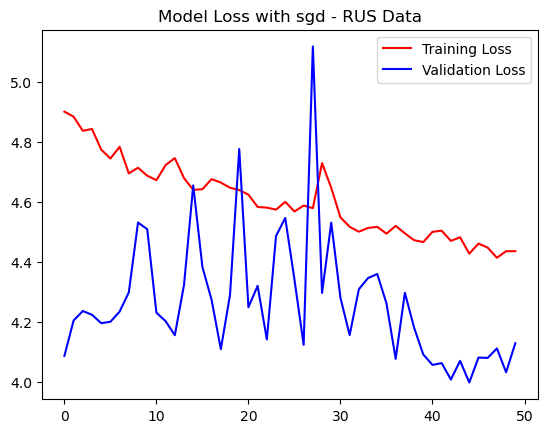

12/12 [==============================] - 0s 7ms/step - loss: 4.1536 - accuracy: 0.2169
Test Accuracy (sgd - RUS Data): 0.21693122386932373
12/12 [==============================] - 0s 5ms/step


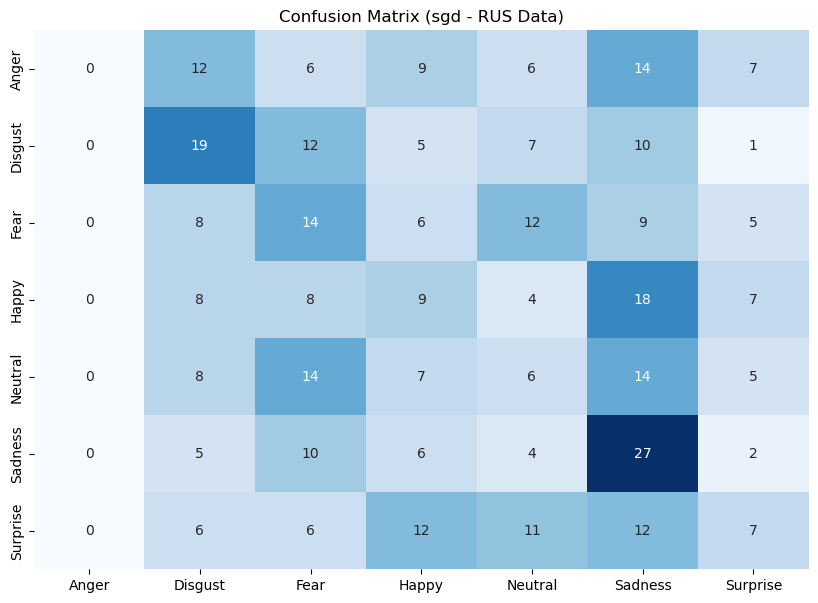

F1 Score (sgd - RUS Data): 0.18934106590292787
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        54
           1      0.288     0.352     0.317        54
           2      0.200     0.259     0.226        54
           3      0.167     0.167     0.167        54
           4      0.120     0.111     0.115        54
           5      0.260     0.500     0.342        54
           6      0.206     0.130     0.159        54

    accuracy                          0.217       378
   macro avg      0.177     0.217     0.189       378
weighted avg      0.177     0.217     0.189       378



2024/09/14 20:41:02 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\amenm\AppData\Local\Temp\tmp08srwko4\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\amenm\AppData\Local\Temp\tmp08srwko4\model\data\model\assets
2024/09/14 20:41:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/14 20:42:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run agreeable-deer-576 at: https://dagshub.com/amenallahbenothmen/Emotion_detection_model.mlflow/#/experiments/1/runs/86f9e08b140f4cd591b0715f4073fcc8.
2024/09/14 20:42:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/amenallahbenothmen/Emotion_detection_model.mlflow/#/experiments/1.


In [31]:
for optimizer in optimizers:
    for epochs in epochs_list:
        model = cnn_model(optimizer)
        train_and_evaluate_model(model, datagen=datagen_rus, X_train=X_train_rus, y_train=y_train_rus, X_val=X_val_rus, y_val=y_val_rus, X_test=X_test_rus, y_test=y_test_rus, optimizer_name=f"{optimizer} - RUS Data", epochs=epochs, valgen=valgen_rus)

In [25]:
model = cnn_model('adam',lr=0.000025)

Epoch 1/75
689/689 [==============================] - 65s 65ms/step - loss: 4.3069 - accuracy: 0.2183 - val_loss: 9.6952 - val_accuracy: 0.1338
Epoch 2/75
689/689 [==============================] - 44s 64ms/step - loss: 3.9620 - accuracy: 0.2570 - val_loss: 3.8775 - val_accuracy: 0.2588
Epoch 3/75
689/689 [==============================] - 44s 63ms/step - loss: 3.7471 - accuracy: 0.2796 - val_loss: 3.6243 - val_accuracy: 0.2769
Epoch 4/75
689/689 [==============================] - 39s 56ms/step - loss: 3.5424 - accuracy: 0.3025 - val_loss: 3.5101 - val_accuracy: 0.2906
Epoch 5/75
689/689 [==============================] - 44s 64ms/step - loss: 3.3345 - accuracy: 0.3255 - val_loss: 3.2566 - val_accuracy: 0.3227
Epoch 6/75
689/689 [==============================] - 38s 55ms/step - loss: 3.1312 - accuracy: 0.3470 - val_loss: 3.0566 - val_accuracy: 0.3371
Epoch 7/75
689/689 [==============================] - 36s 53ms/step - loss: 2.9267 - accuracy: 0.3734 - val_loss: 2.8192 - val_accuracy:

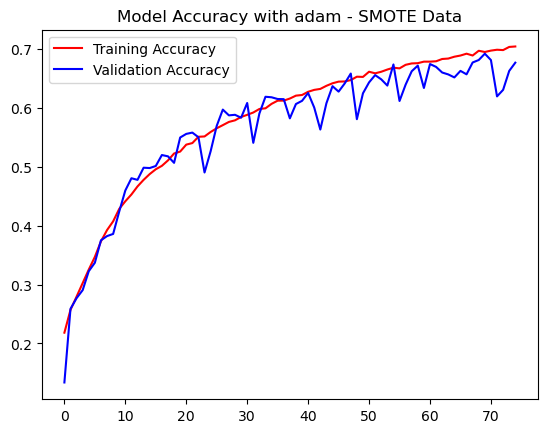

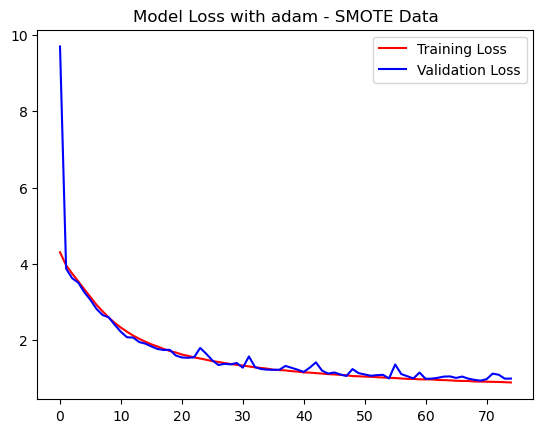

197/197 [==============================] - 2s 8ms/step - loss: 0.9242 - accuracy: 0.7059
Test Accuracy (adam - SMOTE Data): 0.7058542966842651
197/197 [==============================] - 1s 5ms/step


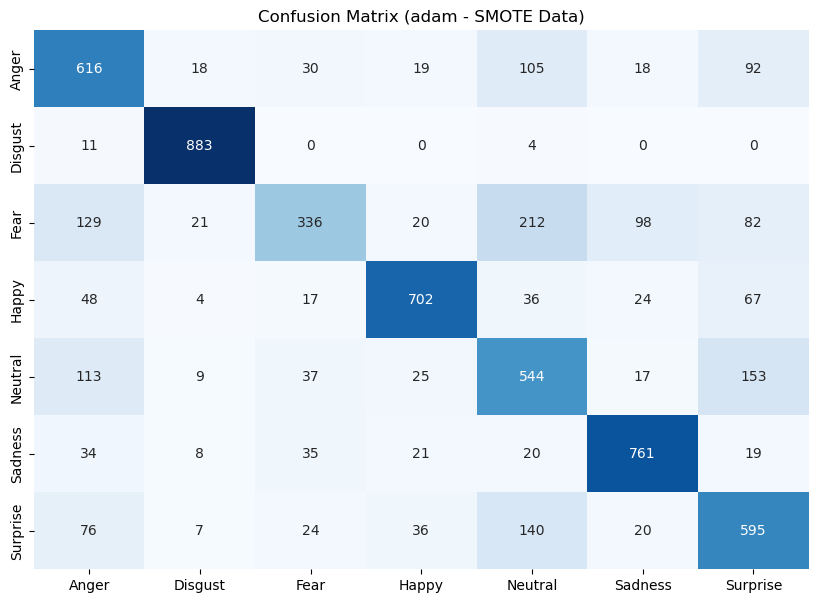

F1 Score (adam - SMOTE Data): 0.7011650730502514
              precision    recall  f1-score   support

           0      0.600     0.686     0.640       898
           1      0.929     0.983     0.956       898
           2      0.701     0.374     0.488       898
           3      0.853     0.782     0.816       898
           4      0.513     0.606     0.555       898
           5      0.811     0.847     0.829       898
           6      0.590     0.663     0.624       898

    accuracy                          0.706      6286
   macro avg      0.714     0.706     0.701      6286
weighted avg      0.714     0.706     0.701      6286



2024/09/16 17:52:17 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\amenm\AppData\Local\Temp\tmp6urdyy5q\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\amenm\AppData\Local\Temp\tmp6urdyy5q\model\data\model\assets
2024/09/16 17:52:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/16 17:55:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run dashing-doe-189 at: https://dagshub.com/amenallahbenothmen/Emotion_detection_model.mlflow/#/experiments/1/runs/cfc3c29f541346779e1c374477a05e59.
2024/09/16 17:55:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/amenallahbenothmen/Emotion_detection_model.mlflow/#/experiments/1.


In [26]:
train_and_evaluate_model(model, datagen=datagen_smote, X_train=X_train_smote, y_train=y_train_smote, X_val=X_val_smote, y_val=y_val_smote, X_test=X_test_smote, y_test=y_test_smote, optimizer_name="adam - SMOTE Data", epochs=75, valgen=valgen_smote)